[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/tut8_RNN_NLP2_student.ipynb)

# Tutorial 8: Text classification considering words as sequence
In [tutorial 5](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/tut5_embeddings_teacher.ipynb), we saw how to classify the reviews in `IMBD` dataset into positive and negative sentiments. However, the approach didn't consider the order of the words in the review. Therefore, in this tutorial, we consider the sequence model approach rather than following the 'bag-of-words' model. 

For this purpose, we cover
1. Load and prepare the well-known IMBD dataset for the sequence model approach.
2. Masking, a way to tell RNNs to skip meaningless inputs
3. Bidirectional RNNs
4. GRU RNN 

For further examples, please visit [demos/nlp/sentiment_analysis.ipynb](https://github.com/Humboldt-WI/adams/blob/master/demos/nlp/sentiment_analysis.ipynb).

## Preprocess IMDB data for the sequence model approach

In [2]:
# Import the required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import string
import re
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

# load the data (be sure to provide the correct file path)
total_imbd = pd.read_csv("IMDB-50K-Movie-Review.zip", sep=",", encoding="ISO-8859-1")
total_imbd['sentiment'] = total_imbd['sentiment'].map({'positive' : 1, 'negative': 0})
# Split the data
X_train, X_val, y_train, y_val = train_test_split(total_imbd['review'], total_imbd['sentiment'], test_size = 0.2, random_state = 5)
# transform them to numpy 
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# define standarization function 
def our_standardization(text_data):
  lowercase = tf.strings.lower(text_data) # convert to lowercase
  remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
  pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
  remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
  remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
  return remove_double_spaces

# Define the size of the vocabulary and the max number of words in a sequence
vocab_size = 10000
seq_length = 500

# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )
vectorize_layer.adapt(X_train)
## Transform sequences of words to seq of integers and labels to tensor
X_train = vectorize_layer(X_train)
X_val = vectorize_layer(X_val)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)


<tf.Tensor: shape=(40000,), dtype=int64, numpy=array([0, 1, 0, ..., 1, 0, 1], dtype=int64)>

## Masking, a way to tell RNNs to skip meaningless inputs (padding)
If our input sequences are full of zeros, that will hurt the model's performance. In our case, we have lots of zeros because we're using the `output_sequence_length=seq_length` option in `TextVectorization`. That truncates sentences longer than `seq_length` tokens to `seq_length` tokens but also pads shorter sentences with zeros.

The RNN may spend its last iterations only seeing vectors encoding these zeros (short sentences). The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these empty inputs. To avoid this, we use masking. The `Embedding` layer can generate a mask (`mask_zero=True`) corresponding to its input data. This mask tells the RNN (as attached metadata) to skip over the iterations containing only vectors that encode padding.


In [4]:
# Example
ex_emb = layers.Embedding(input_dim = 100, output_dim=16, mask_zero=True)
ex_input = [[5,4,3,2,1,0,0],
            [1,2,3,0,0,0,0]]
ex_emb.compute_mask(ex_input)

<tf.Tensor: shape=(2, 7), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True, False, False],
       [ True,  True,  True, False, False, False, False]])>

### Exercise 1
Create a text classification model with `Embedding`+`LSTM`. Use `emb_size = 32` and `16` units for the RNN.

In [18]:
input = tf.keras.Input(shape=(seq_length,), dtype="int64") 
emb = layers.Embedding(input_dim = vocab_size, output_dim = 32, mask_zero = True)(input)
lstm_layer = layers.LSTM(16)(emb)
output = layers.Dense(1, activation = 'sigmoid')(lstm_layer)

model = tf.keras.Model(input, output)
model.compile(optimizer="rmsprop",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 500)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_7 (Embedding)       │ (None, 500, 32)           │         320,000 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_6 (NotEqual)        │ (None, 500)               │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_6 (LSTM)                 │ (None, 16)                │           3,136 │ embedding_7[0][0],         │
│                               │                           │                 │ not_equal_6[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │              17 │ lstm_6[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 323,153 (1.23 MB)

 Trainable params: 323,153 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

### Exercise 2
Fit the model using only 2 epochs and a `batch_size = 128`.

In [19]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = 128, epochs = 2)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.6420 - loss: 0.6112 - val_accuracy: 0.8591 - val_loss: 0.3608
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.8493 - loss: 0.3618 - val_accuracy: 0.8636 - val_loss: 0.3318


### Exercise 3
Predict the sentiment of the following phrases

`"This movie never stops surprising me. The actors are good."`

`"This movie never stops surprising me. The actors are good. However, the story is terrible."`

In [23]:
X_pred = vectorize_layer(["This movie never stops surprising me. The actors are good.", 
                 "This movie never stops surprising me. The actors are good. However, the story is terrible."])
model.predict(X_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


array([[0.6185952],
       [0.272012 ]], dtype=float32)

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

y_prob_hat = model.predict(X_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step


In [157]:
def plot_auc(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    perfect_score = (0,1)
    sq_eucledian_distance_to_perfect_score = ((fpr - perfect_score[0])**2) + ((tpr - perfect_score[1])**2)
    idx_best_cut = np.argmin(sq_eucledian_distance_to_perfect_score)

    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(3,2, height_ratios=[1,1,0.15])
    #axes = axes.flatten()

    auc_plt = fig.add_subplot(gs[:2,0])
    
    auc_plt.plot(fpr, tpr, label = f"ROC, AUC = {format(roc_auc_score(y_true, y_pred_prob), '.2')}")
    auc_plt.scatter(fpr[idx_best_cut], tpr[idx_best_cut],
                label = f"$\\tau = {format(thresholds[idx_best_cut], '.2')}$", color = "darkgreen")
    auc_plt.set_xlabel('False Positive Rate')
    auc_plt.set_ylabel('True Positive Rate')

    #auc_plt.text(0.8, 0.3, f"AUC = {format(roc_auc_score(y_true, y_pred_prob), '.2')}",
     #            transform=auc_plt.transAxes)
    
    auc_plt.legend(loc = 'center right')
    auc_plt.set_title("ROC displaying the threshold $\\tau$ closest to (0,1)")

    cf_mat_plt = fig.add_subplot(gs[0,1])
    y_pred = (y_pred_prob >= thresholds[idx_best_cut]).astype(int)
    cf_mat_plt.axis('tight')
    cf_mat_plt.axis('off')
    cf_mat = confusion_matrix(y_true, y_pred)
    tbl = cf_mat_plt.table(cellText=cf_mat,
                           colLabels=["$\\mathbf{\\hat{y}=0}$", "$\\mathbf{\\hat{y}=1}$"],
                           rowLabels=["$\\mathbf{y=0}$", "$\\mathbf{y=1}$"],
                           cellLoc='center', loc='center')
    tbl.scale(0.6,1.5)
    
    cf_mat_plt.text(0.09,0.05,"Total observations = " + str(len(y_true))
                    , transform = cf_mat_plt.transAxes
                   )
    cf_mat_plt.set_title("Confussion matrix at $\\tau \\approx$" + format(thresholds[idx_best_cut], '.2'))


    subtitle = fig.add_subplot(gs[-1,:])
    cap = "$\\mathbf{Note:}$ $\\tau$ chosen to be the point in the ROC as the point wiht the lowest eucledian distance to the 'perfect' point i. e. (FPR, TPR) = (0,1)"
    subtitle.axis('off')
    subtitle.text(0,-1, cap, horizontalalignment = 'left', verticalalignment = 'top', transform=subtitle.transAxes)
    
    metrics = fig.add_subplot(gs[1,1])
    metrics.axis('off')

    metrx = {'Accuracy' : (cf_mat[0,0] + cf_mat[1,1]) / np.sum(cf_mat),
         'Precision' : cf_mat[1,1] / np.sum(cf_mat[:,1]),
         'Recall' : cf_mat[1,1] / np.sum(cf_mat[1,:]),
         'MCC' : ((cf_mat[1,1]*cf_mat[0,0])-(cf_mat[0,1]*cf_mat[1,0])) / (((cf_mat[1,1]+cf_mat[0,1])*(cf_mat[1,1]+cf_mat[1,0])*(cf_mat[0,0]+cf_mat[0,1])*(cf_mat[0,0]+cf_mat[1,0])) ** 0.5)}
    metrx['F-score'] = (2*metrx['Precision']*metrx['Recall']) / (metrx['Precision']+metrx['Recall'])

    metrics.table(cellText=np.reshape([format(metric, '.3') for metric in metrx.values()], (-1,1)),
                  rowLabels = ['$\\mathbf{' + name + '}$'for name in metrx.keys()],
                  colLabels = ['$\\mathbf{Value}$'],
                  cellLoc='center', loc='center').scale(0.3,1)
    
    metrics.set_title("Metrics at $\\tau \\approx$" + format(thresholds[idx_best_cut], '.2'))

    
    plt.show()

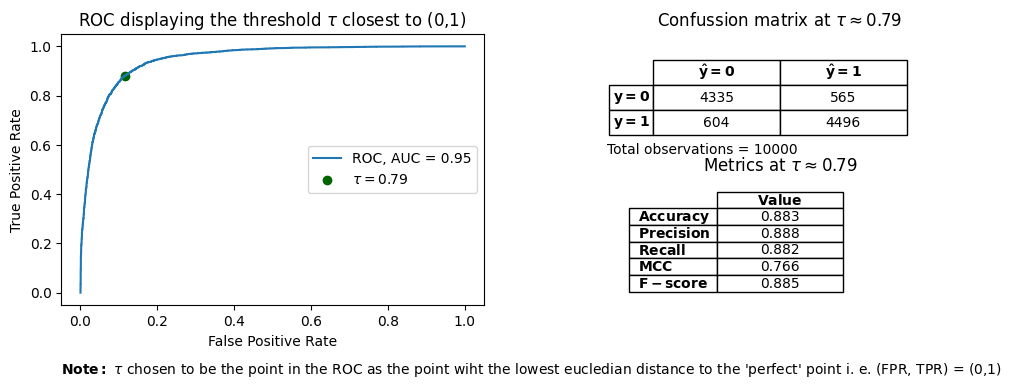

In [158]:
plot_auc(y_val, y_prob_hat)

In [133]:
metrx = [(cf_mat[0,0] + cf_mat[1,1]) / np.sum(cf_mat),
        cf_mat[1,1] / np.sum(cf_mat[:,1])]
metrics_names ['Accuracy', 'Precision', 'Recall']

10000

In [142]:
metrx = {'Accuracy' : (cf_mat[0,0] + cf_mat[1,1]) / np.sum(cf_mat),
         'Precision' : cf_mat[1,1] / np.sum(cf_mat[:,1]),
         'Recall' : cf_mat[1,1] / np.sum(cf_mat[1,:]),
         'MCC' : ((cf_mat[1,1]*cf_mat[0,0])-(cf_mat[0,1]*cf_mat[1,0])) / (((cf_mat[1,1]+cf_mat[0,1])*(cf_mat[1,1]+cf_mat[1,0])*(cf_mat[0,0]+cf_mat[0,1])*(cf_mat[0,0]+cf_mat[1,0])) ** 0.5)}
metrx['F-score'] = (2*metrx['Precision']*metrx['Recall']) / (metrx['Precision']+metrx['Recall'])
metrx

{'Accuracy': 0.8831,
 'Precision': 0.8883619837976684,
 'Recall': 0.8815686274509804,
 'MCC': 0.7661662573873604,
 'F-score': 0.884952268477512}

In [135]:
np.sum(cf_mat[:,1])

5061

In [51]:
min(sq_eucledian_distance_to_perfect_score)n

0.027321491878063743

In [140]:
4 ** 0.5

2.0

array([1.        , 0.99960788, 0.98359723, ..., 0.        , 0.        ,
       0.        ])

[       inf 0.9799636  0.9727758  ... 0.02031805 0.020318   0.01349775]


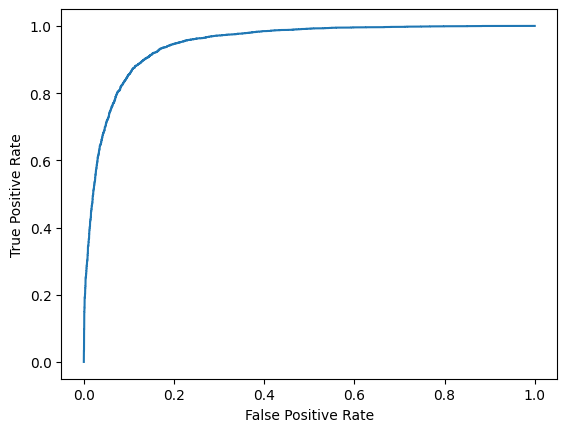

In [34]:
plot_auc(y_val, y_prob_hat)

## Bidirectional LSTM
You have seen that RNNs care about the order (that's why they do well when the sequence order is essential). A bidirectional RNN is a type of recurrent neural network that is trained on two separate data sequences, one in chronological order and the other in reverse order. By doing so, we can learn patterns in both directions. 

If the sequence is formed by words, extracting patterns in both directions makes sense since, a priori, the potential relevance of a word in understanding a phrase is not entirely dependent on its position (the order is determined by the grammar rather than the sequential occurrence).  

| ![](https://www.gabormelli.com/RKB/images/4/4f/BRNN_Mike_Paliwal_1997_Fig3.png) | 
|:--:| 
| (Schuster & Paliwal, 1997) |

You can use `Bidirectional` layer in Keras to create a bidirectional RNN.

```python
inputs = tf.keras.Input(shape=(sequence_length, ))
x = layers.Bidirectional(layers.LSTM(n_units))(inputs)
 ...
 ...
 ...
```


### Exercise 4
Create a new model similar to the previous one but using a `Bidirectional` layer instead of one `LSTM`. Check the number of parameters in the new layer.

### Exercise 5
Fit the model with the same arguments as before

### Exercise 6
Predict the sentiment for the previous sentences


In [1]:
# "This movie never stops surprising me. The actors are good."

In [2]:
# "This movie never stops surprising me. The actors are good. However, the story is terrible."

## Try with another RNN
GRU stands for "Gated Recurrent Unit". GRUs are similar to LSTM, but they are more straightforward and were introduced more recently by [Cho et al. (2014)](https://arxiv.org/abs/1409.1259).

![](http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png)

### Exercise 7
Using the `GRU` layer instead of the `LSTM`, create the text classification model and compare if there is a significant gain.